# Notebook
Notebook for prototyping and experimenting. 

### New Simulation Config


In [ ]:

beam_settings = load_beam_config(config["beam"])

lenses = [load_lens_config(lc) for lc in config["lenses"]]
stages = [load_sim_stage_config(sc) for sc in config["stages"]]

options = generate_simulation_options(config, "log")
parameters = generate_simulation_parameters(config)


sim_config = SimulationConfig(
    beam=beam_settings,
    lenses=lenses,
    stages=stages,
    parameters=parameters,
    options=options
)


print("SIM CONFIG:")
pprint(sim_config.beam)
print("-"*50)
pprint(sim_config.lenses)
print("-"*50)
pprint(sim_config.stages)
print("-"*50)
pprint(sim_config.parameters)
print("-"*50)
pprint(sim_config.options)



### DASK Experiments


In [ ]:
import time
import dask


@dask.delayed
def inc(x):
    time.sleep(1)
    return x + 1

@dask.delayed
def add(x, y):
    time.sleep(1)
    return x + y

In [ ]:
%%time

a = inc(1)
b = inc(1)
c = add(a, b)
c.visualize("mydask.png")
# c.dask
# c = c.compute()


In [ ]:
import zarr

arr = zarr.ones(shape=(100, 10000, 10000))

import dask.array as da

darr = da.from_zarr(arr) * np.arange(arr.shape[1])

import matplotlib.pyplot as plt

plt.imshow(darr[0, :, :])
plt.show()

### Custom Config

Load a custom config from key (allows for sweeping configs)


In [34]:
%load_ext autoreload
%autoreload 2
from lens_simulation import utils, validation, Simulation, SimulationRunner
from pprint import pprint

from lens_simulation.Lens import generate_lens
from lens_simulation.Medium import Medium

config = utils.load_config("config_minimum.yaml")
config["log_dir"] = "log"


sim_runner = SimulationRunner.SimulationRunner("config.yaml")
sim_runner.setup_simulation()

conf_1 = sim_runner.simulation_configurations[0]
for conf in sim_runner.simulation_configurations:

    pprint(conf)
    print("------------ AFTER -------------- ")
    sim = Simulation.Simulation(conf)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'beam': {'distance_mode': 'Direct',
          'final_diameter': None,
          'final_diameter_step': None,
          'final_diameter_stop': None,
          'focal_multiple': None,
          'focal_multiple_step': None,
          'focal_multiple_stop': None,
          'height': 0.0003,
          'height_step': None,
          'height_stop': None,
          'n_steps': 2,
          'numerical_aperture': None,
          'numerical_aperture_step': None,
          'numerical_aperture_stop': None,
          'output_medium': 1.0,
          'position_x': 0.0,
          'position_x_step': None,
          'position_x_stop': None,
          'position_y': 0.0,
          'position_y_step': None,
          'position_y_stop': None,
          'shape': 'Rectangular',
          'source_distance': 0.0001,
          'source_distance_step': None,
          'source_distance_stop': None,
          'spread': 'Plane',
   

ValueError: Cannot load file containing pickled data when allow_pickle=False

### Mega Stack
Stack multiple simulations together for synchronised visualisation


In [13]:
%load_ext autoreload
%autoreload 2


# TODO: stage stacking


from lens_simulation import utils, plotting
import matplotlib.pyplot as plt
import numpy as np

import dask.array as da

paths = [
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\active-shark",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\fit-jennet",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\moral-skink"
    ]

mega = None
for p in paths:

    sim = plotting.load_full_sim_propagation_v2(p)

    if mega is None:
        mega = sim
    else: 
        mega = np.hstack([mega, sim])
    
    print("sim shape: ", sim.shape)
    print("mega shape: ", mega.shape)


print("final: ", mega.shape)

mega_view = plotting.slice_simulation_view(mega)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sim shape:  (110, 2001, 2001)


AttributeError: 'NoneType' object has no attribute 'shape'

In [19]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
import matplotlib.pyplot as plt
import numpy as np

import dask.array as da
import os

paths = [
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\active-shark",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\fit-jennet",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\moral-skink"
    ]

data = []
for p in paths:
    print(f"load sim_{os.path.basename(p)}")
    sim = plotting.load_full_sim_propagation_v2(p)

    data.append(da.from_array(sim))
    
    # print("sim shape: ", sim.shape)
    # print("mega shape: ", mega.shape)

#
mega = da.concatenate(data, axis=1)

print("final: ", mega.shape)

mega_view = plotting.slice_simulation_view(mega)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
load sim_active-shark
load sim_fit-jennet
load sim_moral-skink
final:  (110, 6003, 2001)


In [18]:
import napari
from magicgui import magicgui
from napari.layers import Image
from napari.types import ImageData

# create a viewer and add some images
viewer = napari.Viewer()
viewer.add_image(mega, name="simulation", colormap="turbo", scale=[1, 0.1, 0.1])

# turn the gaussian blur function into a magicgui
# for details on why the `-> ImageData` return annotation works:
# https://napari.org/guides/magicgui.html#return-annotations
@magicgui(
    # tells magicgui to call the function whenever a parameter changes
    auto_call=True,
    # `widget_type` to override the default (spinbox) "float" widget
    prop={"widget_type": "FloatSlider", "max": 1.0},
    axis={"choices": [0, 1, 2]},
    layout="horizontal",
)
def slice_image(layer: Image, prop: float = 0.5, axis: int = 0) -> ImageData:
    """Slice the volume along the selected axis"""
    if layer:
        return plotting.slice_simulation_view(layer.data, axis=axis, prop=prop)

# Add it to the napari viewer
# viewer.window.add_dock_widget(slice_image, area="bottom")

napari.run()

c:\Users\pcle0002\Miniconda3\envs\lens_sim\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


## Gaussian Beam


In [ ]:
# TODO


## Electric Field Refactor
Restructure the simulation to use electric field propagation rather than lenses



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Sim: whole-krill (fc3abbc401) - Plotting Simulation:   0%|          | 0/2 [00:00<?, ?it/s]  c:\Users\pcle0002\Miniconda3\envs\lens_sim\lib\site-packages\matplotlib\contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\Users\pcle0002\Miniconda3\envs\lens_sim\lib\site-packages\matplotlib\contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
Sim: whole-krill (fc3abbc401) - Plotting Simulation:  50%|█████     | 1/2 [00:04<00:01,  1.33s/it]  WARNING:imageio:Lossy conversion from float32 to uint8. Range [0.0, 100000000.0]. Convert image to uint8 prior to saving to suppress this warning.


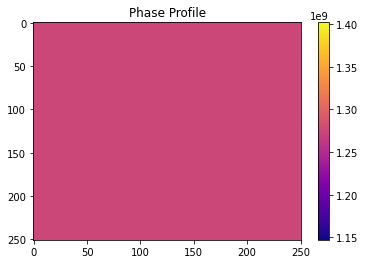

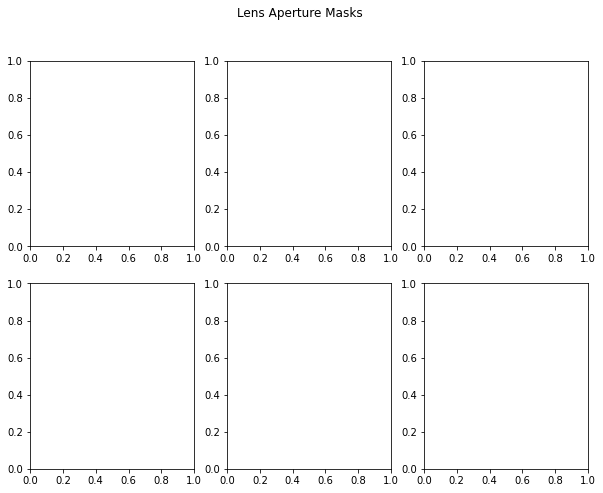

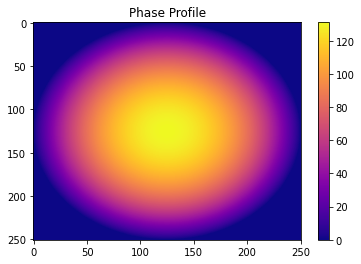

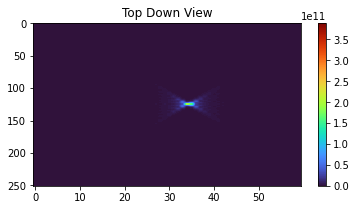

In [29]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
from lens_simulation.beam import generate_beam
from lens_simulation.Simulation import (propagate_wavefront, generate_beam_simulation_stage, generate_simulation_parameters, 
    generate_sq_freq_arr, calculate_wavefront, propagate_over_distance)
from lens_simulation import Simulation
from pprint import pprint
from lens_simulation.Lens import Lens
from scipy import fftpack
from lens_simulation.structures import SimulationStage, SimulationParameters, SimulationOptions, SimulationResult
from tqdm import tqdm
import numpy as np
import zarr
import matplotlib.pyplot as plt

path = "test"
config = utils.load_config("example/sim_focus_2d.yaml")
config["log_dir"] = path

sim = Simulation.Simulation(config)
sim.run_simulation()

fig = plotting.plot_sim_propagation_v2(sim.options.log_dir)
plt.show()
